In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import sep as sep
import Data
import os
import seaborn as sns
import matplotlib.lines as mlines

In [2]:
# exp_list = [11,12,13,16,17,18,19,20,21,22,23,24]
exp_list = [11, 18, 19, 20, 16, 17, 21, 22, 23, 24]

In [3]:
root_path = 'Y:\Lior&Einav\Experiments'
exp_details = pd.read_excel(root_path + sep + 'Experiments_details.xlsx', engine='openpyxl')
exp_details

,Experiment,Larvae_present,Colony,P_yellow,C_yellow,P_red,C_red
0,pilot,no,B,2,1,1,3
1,11,yes,A,2,1,1,3
2,12,no,A,2,1,1,3
3,13,no,A,2,1,1,3
4,16,no,B,2,1,1,3
5,17,no,B,2,1,1,3
6,18,yes,A,2,1,1,3
7,19,yes,A,2,1,1,3
8,20,yes,A,2,1,1,3
9,21,no,B,2,1,1,3


In [4]:
def get_exp_path(exp_num, root_path):
    folderlist = os.listdir(root_path)
    exp_folder = [x for x in folderlist if x.startswith('experiment'+str(exp_num))]
    return root_path + sep + exp_folder[0]

In [5]:
def get_PC_ratios_dict(exp_details,row_idx):
    PC_ratios_dict = {}
    for color in ['yellow', 'red']:
        PC_ratios_dict[color] = [exp_details.loc[row_idx,'P_'+color], exp_details.loc[row_idx,'C_'+color]]
    return PC_ratios_dict

In [6]:
exp_details.index[exp_details.Experiment==13][0]

3

Text(51, 23, '1:2')

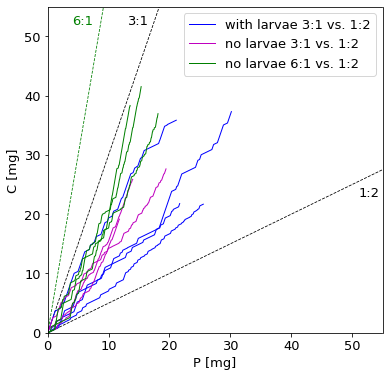

In [7]:
# %matplotlib inline

#plt.figure
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=[6,6])
m = 30 #18
n = 30 #12
plt.plot([0, m*2],[0, m*1],'--k',linewidth=0.8)
plt.plot([0,n*1],[0, n*3],'--k',linewidth=0.8)
plt.plot([0,n*1],[0, n*6],'--g',linewidth=0.8)
plt.xlim([0,55])
plt.ylim([0,55])
plt.xlabel('P [mg]')
plt.ylabel('C [mg]')

legend_dict = {'b':'with larvae 3:1 vs. 1:2', 'm':'no larvae 3:1 vs. 1:2','g':'no larvae 6:1 vs. 1:2'}
existing_colors=[]
for exp_num in exp_list:
    exp_path = get_exp_path(exp_num, root_path)
    
    exp_idx = exp_details.index[exp_details.Experiment==exp_num][0]
    PC_ratios_dict = get_PC_ratios_dict(exp_details,exp_idx)
    
    if exp_details.loc[exp_idx,'Colony'] == 'A':
        c = 'b'
    elif exp_details.loc[exp_idx,'C_red'] == 6:
        c = 'g'
    else:
        c = 'm'
    
    
    fdata = pd.read_csv(exp_path + sep + 'forager_table_with_feeding_sizes_ul_transparency_corrected.csv')
    fdata[['P_mg','C_mg']] = fdata.apply(lambda x: pd.Series(Data.food_volume_to_PC_amounts(
        x['feeding_size_ul'],PC_ratios_dict[x['food_source']])),axis=1)

    fdata = fdata.sort_values(by='feeding_start')
    fdata['cumP_mg'] = np.cumsum(fdata['P_mg'])
    fdata['cumC_mg'] = np.cumsum(fdata['C_mg'])
    
    h, = plt.plot(np.insert(fdata['cumP_mg'].to_numpy(),0,0),np.insert(fdata['cumC_mg'].to_numpy(),0,0), c, linewidth=1)
    if c not in existing_colors:
        h.set_label(legend_dict[c])
        existing_colors.append(c)

plt.legend()
plt.text(4,52,'6:1',{'color':'g'})
plt.text(13,52,'3:1')
plt.text(51,23,'1:2')

In [8]:
def get_exp_data(exp_num, exp_details, root_path):
    exp_path = get_exp_path(exp_num, root_path)
    exp_idx = exp_details.index[exp_details.Experiment==exp_num][0]
    PC_ratios_dict = get_PC_ratios_dict(exp_details,exp_idx)
    fdata = pd.read_csv(exp_path + sep + 'forager_table_with_feeding_sizes_ul_transparency_corrected.csv')
    
    return exp_idx, PC_ratios_dict, fdata, exp_path

In [9]:
def plot_exp_trajectory(fdata, PC_ratios_dict, ax, color):    
    fdata[['P_mg','C_mg']] = fdata.apply(lambda x: pd.Series(Data.food_volume_to_PC_amounts(
        x['feeding_size_ul'],PC_ratios_dict[x['food_source']])),axis=1)

    fdata = fdata.sort_values(by='feeding_start')
    fdata['cumP_mg'] = np.cumsum(fdata['P_mg'])
    fdata['cumC_mg'] = np.cumsum(fdata['C_mg'])
    
    # food rails
    m = 29
    n = 22
    x_p = PC_ratios_dict['yellow'][0]
    y_p = PC_ratios_dict['yellow'][1]
    x_c = PC_ratios_dict['red'][0]
    y_c = PC_ratios_dict['red'][1]
    ax.plot([0, m*x_p],[0, m*y_p],'k',linewidth=0.8)
    ax.plot([0,n*x_c],[0, n*y_c],'k',linewidth=0.8)
    
    # colony intake line
    finalP = fdata['cumP_mg'].iloc[-1]
    finalC = fdata['cumC_mg'].iloc[-1]
    ax.plot([0,finalP],[0,finalC],'--k',linewidth=1)
    
    max_lim = max(finalP, finalC)*1.1
    
    ax.plot(np.insert(fdata['cumP_mg'].to_numpy(),0,0),np.insert(fdata['cumC_mg'].to_numpy(),0,0), color, linewidth=1)
    ax.set_xlim([0,max_lim])
    ax.set_ylim([0,max_lim])
    ax.set_aspect('equal', 'box')

In [10]:
exp_details = exp_details.drop(index=0)  # remove pilot experiment
#exps_to_remove = [20, 23]
#exp_details = exp_details.drop(exp_details[exp_details.Experiment.isin(exps_to_remove)].index)
exp_details

,Experiment,Larvae_present,Colony,P_yellow,C_yellow,P_red,C_red
1,11,yes,A,2,1,1,3
2,12,no,A,2,1,1,3
3,13,no,A,2,1,1,3
4,16,no,B,2,1,1,3
5,17,no,B,2,1,1,3
6,18,yes,A,2,1,1,3
7,19,yes,A,2,1,1,3
8,20,yes,A,2,1,1,3
9,21,no,B,2,1,1,3
10,22,no,B,2,1,1,6


In [11]:
larvae_present = exp_details.Experiment[exp_details.Larvae_present == 'yes'].to_list()
no_larvae = exp_details.Experiment[(exp_details.Colony == 'B') & (exp_details.C_red==3)].to_list()
extra_sugar = exp_details.Experiment[exp_details.C_red==6].to_list()

In [12]:
%matplotlib qt
fig, ax = plt.subplots(2,4)
counter = 0
for exp_num in larvae_present:
    exp_idx, PC_ratios_dict, fdata, exp_path = get_exp_data(exp_num, exp_details, root_path)
    plot_exp_trajectory(fdata, PC_ratios_dict, ax[0,counter], 'b')
    counter += 1
    
counter = 0
for exp_num in no_larvae:
    exp_idx, PC_ratios_dict, fdata, exp_path = get_exp_data(exp_num, exp_details, root_path)
    plot_exp_trajectory(fdata, PC_ratios_dict, ax[1,counter], 'm')
    counter += 1

fig.delaxes(ax[1][3])
plt.tight_layout()

In [ ]:
no_larvae